In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
maximum_fitness = 1
statistics=[[],[],[]]

In [3]:
def probability(individual):
    return (fitness(individual) / maximum_fitness)

In [4]:
def selection(population, population_fitness,gen):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(population)
    df=kmeans.labels_
    indexes_for_cluster_0=np.where(df==0)
    population_cluster_0= [population[int(i)] for i in indexes_for_cluster_0[0]]
    indexes_for_cluster_1=np.where(df==1)
    population_cluster_1= [population[int(i)] for i in indexes_for_cluster_1[0]]
    
    probabilities_0 = [probability(n) for n in population_cluster_0]
    probabilities_1 = [probability(n) for n in population_cluster_1]
    sel_type = get_selection_type(gen)
    if sel_type=='random pick':
#         print("random pick")
        x = random_pick(population_cluster_0, probabilities_0)
        y = random_pick(population_cluster_1, probabilities_1)
    elif sel_type=='roulette pick':
#         print("r pick")
        x = roulette_wheel(population_cluster_0)
        y = roulette_wheel(population_cluster_1)
    elif sel_type=='tournament pick':
#         print("t pick")
        x = tournament_selection(population_cluster_0)
        y = tournament_selection(population_cluster_1)
    elif sel_type=='rank pick':
#         print("rank pick")
        x = rank_selection(population_cluster_0)
        y = rank_selection(population_cluster_1)
    return (x, y)

In [5]:
def init(n):
    return [random.randrange(2) for _ in range(n)]


In [6]:
def nbr(x):
    x = x.copy()
    i = random.randrange(len(x))
    x[i] = 1 - x[i]
    return x

In [7]:
def uniform_crossover(p1, p2):
    c1, c2 = [], []
    for i in range(len(p1)):
        if random.random() < 0.5:
            c1.append(p1[i]); c2.append(p2[i])
        else:
            c1.append(p2[i]); c2.append(p1[i])
    return np.array(c1), np.array(c2)

In [8]:
def get_selection_type(generation):
  if generation % 4 == 0:
    return 'random pick'
  elif generation % 4 == 2:
    return 'roulette pick'
  elif generation % 4 == 3:
    return 'tournament pick'
  elif generation % 4 == 1:
    return 'rank pick'

In [9]:
def random_pick(population, probabilities):
    populationWithProbabilty = zip(population, probabilities)
    total = sum(w for c, w in populationWithProbabilty)
    r = random.uniform(0, total)
    upto = 0
    for c, w in zip(population, probabilities):
        if upto + w >= r:
            return c
        upto += w
        
def roulette_wheel(population):
    sum_ = sum([fitness(c) for c in population])
    selection_probs = [fitness(c) / sum_ for c in population]
    return population[npr.choice(len(population), p=selection_probs)]

def tournament_selection(population):
    parents = random.choices(population, k=5)
    parents = sorted(parents, key=lambda agent: fitness(agent), reverse=True)
    return parents[0]

def remove_duplicates(test_list):
    population_tuples = [tuple(x) for x in test_list]
    res = []
    for i in population_tuples:
        if i not in res:
            res.append(i)
    return res

def rank_selection(population):   
    population = remove_duplicates(list(population))
    population = [list(x) for x in population]
#     print(population)
    pop_size = len(population)
    max = pop_size * (pop_size + 1) / 2
    fitness_list = [fitness(c) for c in population]
    population_tuples = [tuple(x) for x in population]
    chromosomes = dict(zip(population_tuples, fitness_list))
    chromosomes = {k: v for k, v in sorted(chromosomes.items(), key=lambda item: item[1])}
    selection_probs = []
    for i in range(pop_size):
        selection_probs.append((i + 1) / max)
    sorted_population = list(chromosomes.keys())
    return list(sorted_population[npr.choice(len(sorted_population), p=selection_probs)])

In [10]:
def GA(f, init, nbr, crossover, select, popsize, ngens, pmut):   
    pop = [init() for _ in range(popsize)]
    popfit = [f(x) for x in pop]
    stats(0, popfit)
    for gen in range(1, ngens):
        newpop = []
        bestidx = min(range(popsize), key=lambda i: popfit[i])
        best = pop[bestidx]
        newpop.append(best) 
        while len(newpop) < popsize:
            p1, p2 = select(pop, popfit, gen)
            c1, c2 = crossover(p1, p2)
            if random.random() < pmut:
                c1 = nbr(c1)
            if random.random() < pmut:
                c2 = nbr(c2)
            newpop.append(c1)
            if len(newpop) < popsize:
                newpop.append(c2)
        pop = newpop
        popfit = [f(x) for x in pop]
        stats(gen, popfit)
    bestidx = np.argmax(popfit)
    return popfit[bestidx], pop[bestidx]


In [11]:
def stats(gen, popfit):
    statistics[0].append(gen)
    statistics[1].append(max(popfit))
    statistics[2].append(np.mean(popfit))

In [12]:
X, y = load_boston(return_X_y=True)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
LR = LinearRegression()


In [13]:
def fitness(x):
    if sum(x) == 0:
        return 0
    else:
        x = [bool(xi) for xi in x] 
        Xtrain_tmp = Xtrain[:, x]
        Xtest_tmp = Xtest[:, x]
        LR.fit(Xtrain_tmp, ytrain)
        return LR.score(Xtest_tmp, ytest)

In [14]:
n = 13
popsize = 100
ngens = 100
pmut = 0.1
bestf, best = GeneticAlgorithm(fitness,
                    lambda: init(n),
                    nbr,
                    uniform_crossover,
                    lambda pop, popfit, gen: selection(pop, popfit,gen),
                    popsize,
                    ngens,
                    pmut
                   )
 

print("bestf : ",bestf)
print("best independent features selected by genetic algorithm : ",best)

bestf :  0.07092684445215669
best independent features selected by genetic algorithm :  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


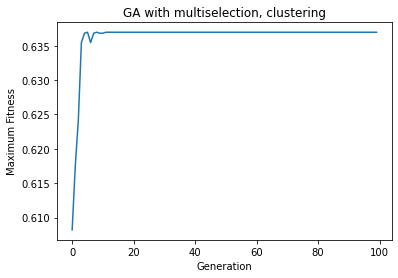

In [15]:
plt.plot(statistics[0],statistics[1])
plt.xlabel('Generation')
plt.ylabel('Maximum Fitness')
plt.title('GA with multiselection, clustering')
plt.show()

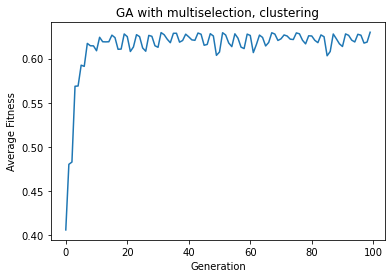

In [20]:
plt.plot(statistics[0],statistics[2])
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('GA with multiselection, clustering')
plt.show()

In [17]:
print("generation with max fitness ",statistics[0][statistics[1].index(max(statistics[1]))])

generation with max fitness  5


In [19]:
print("max fitness" , max(statistics[1]))

max fitness 0.6369666437456365
